In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

/data/home/arifhandoyo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [3]:
# Parameters
kdprov='32'
kdprov = 94


In [10]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()


nMax = 1400 #change to 2500

df = df.groupby('observation').apply(lambda x: x.sample(n=min(nMax, len(x))))

df['observation'].value_counts()

(39895, 44)


observation
0    1400
1    1400
2    1400
3    1400
4    1400
5    1400
6    1400
Name: count, dtype: int64

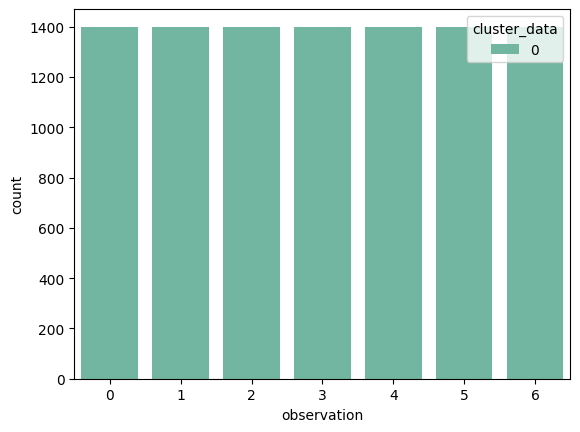

In [11]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')


### Running Data

In [12]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [13]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[I 2024-10-25 13:52:13,594] A new study created in memory with name: no-name-c3bd369e-8f7f-41a4-b43a-bdd4e90821c9


[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-25 13:52:19,966] Trial 0 finished with value: 0.4297634345007746 and parameters: {'max_depth': 9, 'learning_rate': 0.0830564727719715, 'reg_lambda': 1.252501668876073, 'min_child_weight': 73}. Best is trial 0 with value: 0.4297634345007746.
[I 2024-10-25 13:52:27,567] Trial 1 finished with value: 0.4330172857582279 and parameters: {'max_depth': 9, 'learning_rate': 0.05961309043186312, 'reg_lambda': 1.9260299424972818, 'min_child_weight': 65}. Best is trial 1 with value: 0.4330172857582279.
[I 2024-10-25 13:52:43,433] Trial 2 finished with value: 0.41075935942260305 and parameters: {'max_depth': 6, 'learning_rate': 0.018664992561787348, 'reg_lambda': 4.9667753558466385, 'min_child_weight': 64}. Best is trial 1 with value: 0.4330172857582279.
[I 2024-10-25 13:52:50,804] Trial 3 finished with value: 0.4368735748654305 and parameters: {'max_depth': 10, 'learning_rate': 0.06285429947173064, 'reg_lambda': 2.208236541470173, 'min_child_weight': 51}. Best is trial 3 with value: 0.43

Best Parameters: {'max_depth': 10, 'learning_rate': 0.06285429947173064, 'reg_lambda': 2.208236541470173, 'min_child_weight': 51}
Best Score: 0.4368735748654305
Start the modelling
[0]	train-mlogloss:1.88917	eval-mlogloss:1.91781
[100]	train-mlogloss:0.37245	eval-mlogloss:1.54352
[200]	train-mlogloss:0.16079	eval-mlogloss:1.55865
[300]	train-mlogloss:0.10127	eval-mlogloss:1.59235
[400]	train-mlogloss:0.07640	eval-mlogloss:1.62155
[500]	train-mlogloss:0.06284	eval-mlogloss:1.64441
[600]	train-mlogloss:0.05433	eval-mlogloss:1.66149
[700]	train-mlogloss:0.04858	eval-mlogloss:1.67725
[800]	train-mlogloss:0.04449	eval-mlogloss:1.69120
[900]	train-mlogloss:0.04136	eval-mlogloss:1.70182
[1000]	train-mlogloss:0.03888	eval-mlogloss:1.71347
[1100]	train-mlogloss:0.03686	eval-mlogloss:1.72239
[1112]	train-mlogloss:0.03665	eval-mlogloss:1.72332
[0]	train-mlogloss:1.89011	eval-mlogloss:1.91693
[100]	train-mlogloss:0.37743	eval-mlogloss:1.51065
[200]	train-mlogloss:0.16099	eval-mlogloss:1.53002
[300

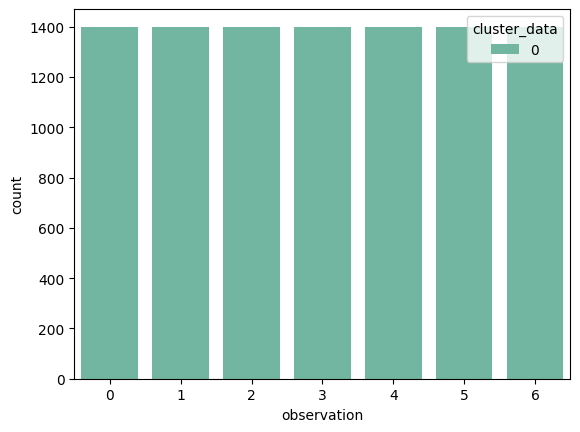

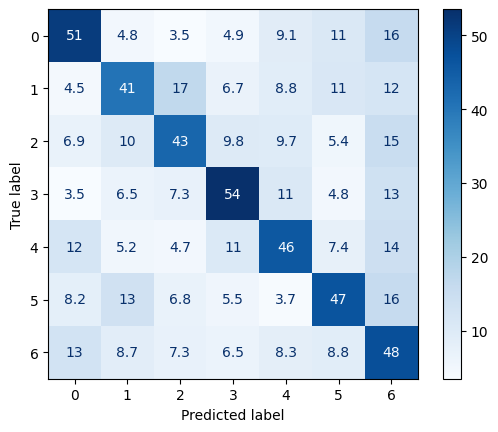

{'average_accuracy': 0.42687074829931976, 'average_f1_macro': 0.42656410380465687, 'average_f1_micro': 0.42687074829931976, 'average_auc': 0.7860572562358277, 'average_acc_kelas_generatif': 0.4761904761904762, 'average_acc_fase_padi': 0.4148809523809524}
{'val_accuracy': 0.46924198250728866, 'val_f1_macro': 0.470520097614402, 'val_f1_micro': 0.46924198250728866, 'val_auc': 0.8235240648737628, 'val_acc_kelas_generatif': 0.5357142857142857, 'val_acc_fase_padi': 0.4576530612244898, 'val_relative_acc': 83.72574385510997}


[I 2024-10-25 07:25:08,412] Trial 15 finished with value: 0.471315210372379 and parameters: {'max_depth': 10, 'learning_rate': 0.05153835164172826, 'reg_lambda': 2.311756543428877, 'min_child_weight': 71}. Best is trial 12 with value: 0.47497433884892554.


[I 2024-10-25 07:25:57,234] Trial 16 finished with value: 0.46746761106610074 and parameters: {'max_depth': 7, 'learning_rate': 0.029577451337261088, 'reg_lambda': 4.98130931446365, 'min_child_weight': 73}. Best is trial 12 with value: 0.47497433884892554.


[I 2024-10-25 07:26:50,606] Trial 17 finished with value: 0.470550109251409 and parameters: {'max_depth': 10, 'learning_rate': 0.032094791274092385, 'reg_lambda': 3.022674417743192, 'min_child_weight': 100}. Best is trial 12 with value: 0.47497433884892554.


[I 2024-10-25 07:27:22,722] Trial 18 finished with value: 0.46905135259545877 and parameters: {'max_depth': 8, 'learning_rate': 0.053484328662466885, 'reg_lambda': 1.6148393434560804, 'min_child_weight': 86}. Best is trial 12 with value: 0.47497433884892554.


[I 2024-10-25 07:27:42,040] Trial 19 finished with value: 0.4744910164912601 and parameters: {'max_depth': 10, 'learning_rate': 0.09137640694085908, 'reg_lambda': 3.631733590297949, 'min_child_weight': 76}. Best is trial 12 with value: 0.47497433884892554.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.04359192543420393, 'reg_lambda': 4.736828578737553, 'min_child_weight': 83}
Best Score: 0.47497433884892554
Start the modelling
[0]	train-mlogloss:1.90254	eval-mlogloss:1.91947


[100]	train-mlogloss:0.61835	eval-mlogloss:1.27010


[200]	train-mlogloss:0.37896	eval-mlogloss:1.16383


[300]	train-mlogloss:0.25484	eval-mlogloss:1.11164


[400]	train-mlogloss:0.19027	eval-mlogloss:1.09233


[500]	train-mlogloss:0.15037	eval-mlogloss:1.08670


[600]	train-mlogloss:0.12316	eval-mlogloss:1.08616


[700]	train-mlogloss:0.10359	eval-mlogloss:1.08961


[800]	train-mlogloss:0.08865	eval-mlogloss:1.09459


[900]	train-mlogloss:0.07710	eval-mlogloss:1.10018


[1000]	train-mlogloss:0.06828	eval-mlogloss:1.10655


[1100]	train-mlogloss:0.06154	eval-mlogloss:1.11236


[1200]	train-mlogloss:0.05595	eval-mlogloss:1.11815


[1300]	train-mlogloss:0.05128	eval-mlogloss:1.12354


[1400]	train-mlogloss:0.04739	eval-mlogloss:1.12828


[1500]	train-mlogloss:0.04417	eval-mlogloss:1.13368


[1553]	train-mlogloss:0.04262	eval-mlogloss:1.13686


[0]	train-mlogloss:1.90190	eval-mlogloss:1.91846


[100]	train-mlogloss:0.61148	eval-mlogloss:1.26141


[200]	train-mlogloss:0.38030	eval-mlogloss:1.16140


[300]	train-mlogloss:0.26449	eval-mlogloss:1.11963


[400]	train-mlogloss:0.19617	eval-mlogloss:1.10159


[500]	train-mlogloss:0.15265	eval-mlogloss:1.09351


[600]	train-mlogloss:0.12288	eval-mlogloss:1.09318


[700]	train-mlogloss:0.10277	eval-mlogloss:1.09640


[800]	train-mlogloss:0.08794	eval-mlogloss:1.10194


[900]	train-mlogloss:0.07697	eval-mlogloss:1.10816


[1000]	train-mlogloss:0.06841	eval-mlogloss:1.11496


[1100]	train-mlogloss:0.06153	eval-mlogloss:1.12191


[1200]	train-mlogloss:0.05578	eval-mlogloss:1.12880


[1300]	train-mlogloss:0.05097	eval-mlogloss:1.13598


[1400]	train-mlogloss:0.04706	eval-mlogloss:1.14335


[1500]	train-mlogloss:0.04379	eval-mlogloss:1.14980


[1549]	train-mlogloss:0.04230	eval-mlogloss:1.15247


[0]	train-mlogloss:1.90073	eval-mlogloss:1.92044


[100]	train-mlogloss:0.58795	eval-mlogloss:1.29312


[200]	train-mlogloss:0.36221	eval-mlogloss:1.19214


[300]	train-mlogloss:0.25279	eval-mlogloss:1.14998


[400]	train-mlogloss:0.18905	eval-mlogloss:1.13064


[500]	train-mlogloss:0.14852	eval-mlogloss:1.12451


[600]	train-mlogloss:0.12078	eval-mlogloss:1.12423


[700]	train-mlogloss:0.10126	eval-mlogloss:1.12786


[800]	train-mlogloss:0.08661	eval-mlogloss:1.13321


[900]	train-mlogloss:0.07568	eval-mlogloss:1.14054


[1000]	train-mlogloss:0.06746	eval-mlogloss:1.14800


[1100]	train-mlogloss:0.06085	eval-mlogloss:1.15525


[1200]	train-mlogloss:0.05528	eval-mlogloss:1.16236


[1300]	train-mlogloss:0.05072	eval-mlogloss:1.16858


[1400]	train-mlogloss:0.04699	eval-mlogloss:1.17521


[1500]	train-mlogloss:0.04366	eval-mlogloss:1.18161


[1572]	train-mlogloss:0.04156	eval-mlogloss:1.18585


[0]	train-mlogloss:1.90097	eval-mlogloss:1.91780


[50]	train-mlogloss:0.91242	eval-mlogloss:1.38391


[100]	train-mlogloss:0.62279	eval-mlogloss:1.25003


[150]	train-mlogloss:0.49562	eval-mlogloss:1.18902


[200]	train-mlogloss:0.40617	eval-mlogloss:1.14633


[250]	train-mlogloss:0.34134	eval-mlogloss:1.11628


[300]	train-mlogloss:0.28922	eval-mlogloss:1.09281


[350]	train-mlogloss:0.24587	eval-mlogloss:1.07480


[400]	train-mlogloss:0.21566	eval-mlogloss:1.06367


[450]	train-mlogloss:0.19177	eval-mlogloss:1.05552


[500]	train-mlogloss:0.17145	eval-mlogloss:1.04994


[550]	train-mlogloss:0.15499	eval-mlogloss:1.04660


[600]	train-mlogloss:0.13993	eval-mlogloss:1.04386


[650]	train-mlogloss:0.12781	eval-mlogloss:1.04239


[700]	train-mlogloss:0.11737	eval-mlogloss:1.04207


[742]	train-mlogloss:0.10969	eval-mlogloss:1.04260



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62      5389
           1       0.58      0.54      0.56      4043
           2       0.54      0.31      0.39      1365
           3       0.53      0.34      0.41      1032
           4       0.54      0.39      0.45      1540
           5       0.50      0.33      0.40      2013
           6       0.68      0.80      0.73     12545

    accuracy                           0.63     27927
   macro avg       0.57      0.48      0.51     27927
weighted avg       0.62      0.63      0.62     27927



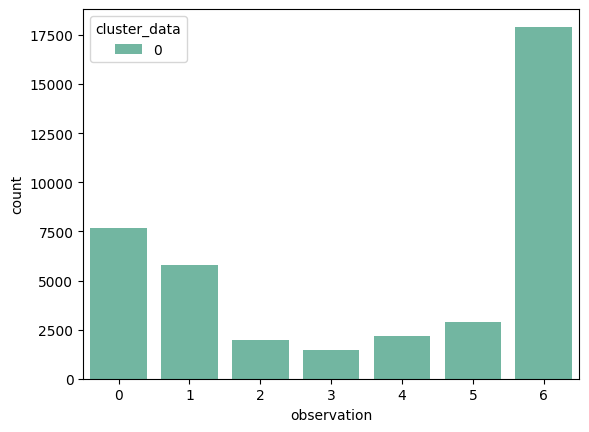

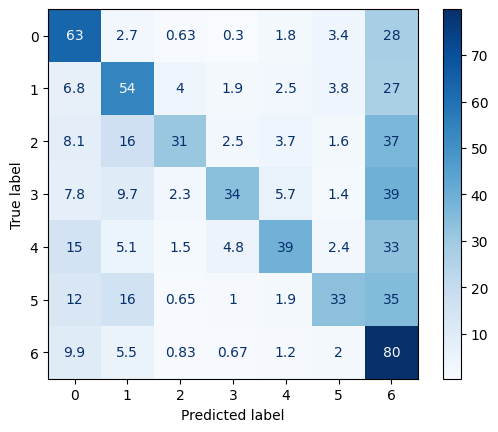

{'average_accuracy': 0.6183987167718744, 'average_f1_macro': 0.4684839960659242, 'average_f1_micro': 0.6183987167718744, 'average_auc': 0.8424458838637636, 'average_acc_kelas_generatif': 0.2934209719924005, 'average_acc_fase_padi': 0.3769005847953217}
{'val_accuracy': 0.6323629462527304, 'val_f1_macro': 0.5108353736782776, 'val_f1_micro': 0.6323629462527304, 'val_auc': 0.8657289151560914, 'val_acc_kelas_generatif': 0.3372093023255814, 'val_acc_fase_padi': 0.4444862155388471, 'val_relative_acc': 91.40263743791745}


In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in np.sort(df.cluster_data.unique()):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=20)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')




In [9]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2_1.pkl','wb') as file:
    pickle.dump(dict_report,file)